### Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import calendar
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Import dataset

In [3]:
dataset = pd.read_csv('data/Border_Crossing_Entry_Data.csv')
dataset.head()

,Port Name,State,Port Code,Border,Date,Measure,Value
0,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicle Passengers,1414
1,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicles,763
2,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Empty,412
3,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Full,122
4,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Trucks,545


##### Checking for missing values

In [4]:
dataset.isna().sum().any()

False

Since the 'Date' column is in mm-dd-yy hh:mm format, it does not serve us any good and so, it should be modified. In order to do that, we will just extract year and month and put them in the separate columns

In [5]:
dataset['Month'] = dataset['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M').month).astype(int)
dataset['Month'] = dataset['Month'].apply(lambda x: calendar.month_abbr[x])
dataset['Year'] = dataset['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M').year)

dataset.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Month,Year
0,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicle Passengers,1414,Feb,2020
1,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Personal Vehicles,763,Feb,2020
2,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Empty,412,Feb,2020
3,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Truck Containers Full,122,Feb,2020
4,Alcan,AK,3104,US-Canada Border,2/1/2020 00:00,Trucks,545,Feb,2020


Next, we will look at how the number of border crossings have taken place throughout the years.

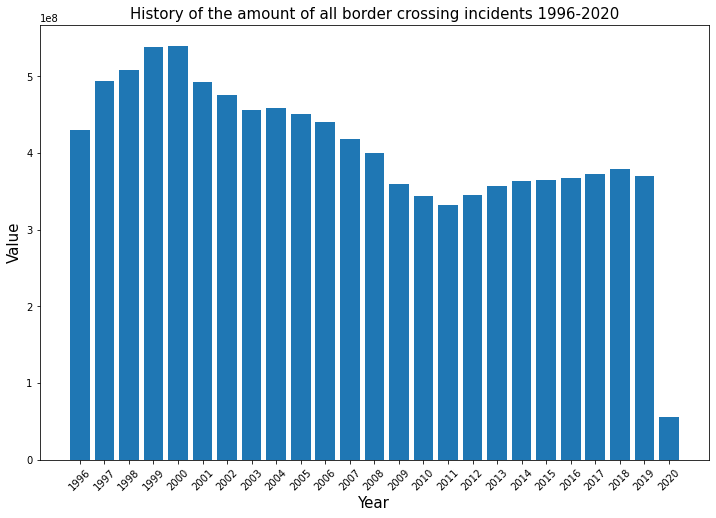

In [6]:
year_value_data = dataset.groupby('Year')['Value'].sum()

plt.figure(figsize=(12, 8))
plt.bar(year_value_data.index, year_value_data.values)
plt.xlabel('Year', fontsize=15)
plt.xticks(year_value_data.index, rotation=45)
plt.ylabel('Value', fontsize=15)
plt.title('History of the amount of all border crossing incidents 1996-2020', fontsize=15)
plt.show()

Now, we differentiate between US-Mexico border and US-Canada to see if we can notice some trends.

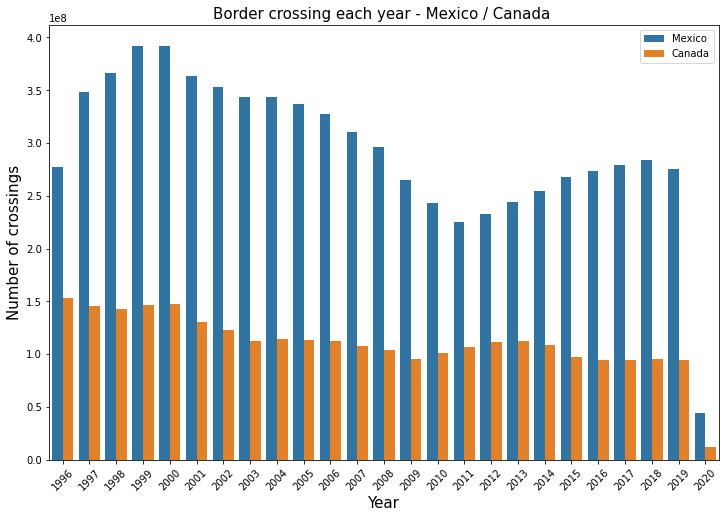

In [7]:
year_value_Mexico = dataset[dataset['Border'] == 'US-Mexico Border'].groupby('Year')['Value'].sum()
year_value_Canada = dataset[dataset['Border'] == 'US-Canada Border'].groupby('Year')['Value'].sum()

year_val_Mexico = pd.DataFrame({
            'Year': year_value_Mexico.index,
            'Country': 'Mexico',
            'Count': year_value_Mexico.values
        })

year_val_Canada = pd.DataFrame({
            'Year': year_value_Canada.index,
            'Country': 'Canada',
            'Count': year_value_Canada.values
        })

year_val_concat = pd.concat([year_val_Mexico, year_val_Canada], ignore_index=True)

# show the plot 
plt.figure(figsize = (12, 8))
sns.barplot(x='Year', y='Count', hue='Country', data=year_val_concat)
plt.title('Border crossing each year - Mexico / Canada ', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Number of crossings', fontsize=15)
plt.legend()
plt.show()

As expected, there has been much more people coming from Mexico than Canada.

In [8]:
mean_month_val = dataset.groupby('Month')['Value'].mean()

# sort in a month order
ordered_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
mean_month_val.index = pd.Categorical(mean_month_val.index, 
                   categories = ordered_months, ordered = True)
mean_month_val = mean_month_val.sort_index()

mean_month_val.head()

Jan    26864.096154
Feb    25080.809680
Mar    28576.007997
Apr    27566.391737
May    28941.046087
Name: Value, dtype: float64

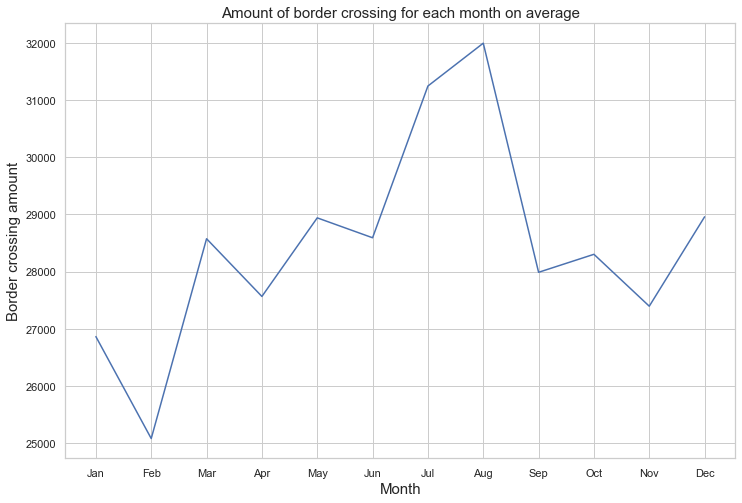

In [15]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
sns.lineplot(data=mean_month_val)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Border crossing amount', fontsize=15)
plt.title('Average number of border crossings per month', fontsize=15)
plt.show()

##### Popular forms of transport - Mexico

In [9]:
transport_data_Mexico = dataset[dataset['Border'] == 'US-Mexico Border']

transport_Mexico_overview = transport_data_Mexico.groupby('Measure')['Value'].sum()
transport_Mexico_overview.sort_values(ascending=False, inplace=True)

print('Most popular transport on Mexican border')
for i, (transport, value) in enumerate(zip(transport_Mexico_overview.index, transport_Mexico_overview)):
    print(f"{i+1}. {transport}: {value}")

Most popular transport on Mexican border
1. Personal Vehicle Passengers: 4043076782
2. Personal Vehicles: 1890535412
3. Pedestrians: 1076593384
4. Trucks: 117244433
5. Truck Containers Full: 74970813
6. Bus Passengers: 70092929
7. Truck Containers Empty: 41057442
8. Rail Containers Empty: 9350352
9. Rail Containers Full: 8281197
10. Buses: 5589037
11. Train Passengers: 295479
12. Trains: 213450


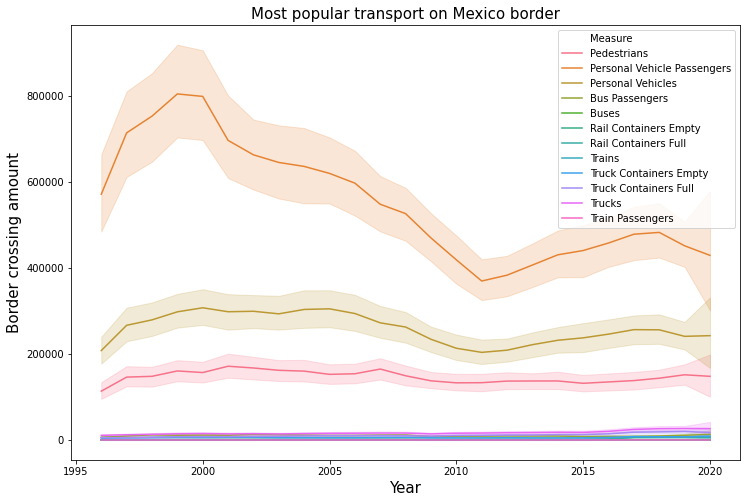

In [10]:
# line plot, a line for each transport
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Value', hue='Measure', data=transport_data_Mexico)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Border crossing amount', fontsize=15)
plt.title('Most popular transport on Mexico border', fontsize=15)
plt.show()

As we can see, people tend to travel in cars either as drivers or passengers. However, we can see that in the recent years this number has been decreasing, whearas travelling on foot has remained in the same state. The other forms of transport are difficult to describe right now due to the graph compression so, let's plot them separately.

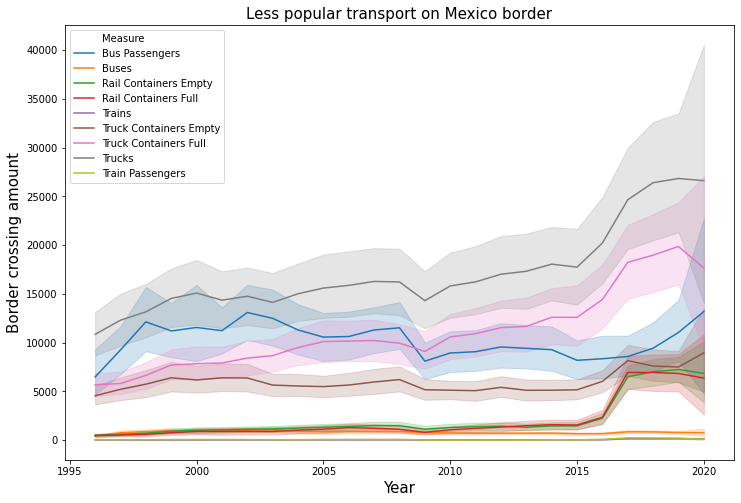

In [11]:
transport_data_Mexico_low = transport_data_Mexico[(transport_data_Mexico['Measure'] != 'Personal Vehicle Passengers') &
                                                  (transport_data_Mexico['Measure'] != 'Personal Vehicles') &
                                                  (transport_data_Mexico['Measure'] != 'Pedestrians')]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Value', hue='Measure', data=transport_data_Mexico_low)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Border crossing amount', fontsize=15)
plt.title('Less popular transport on Mexico border', fontsize=15)
plt.show()                         

From both of these plots we can notice how travelling in a personal vehicle has been becoming less and less popular, while the usage of trucks have increased. That could mean, that US is not necessarily welcoming those people and they tend to illegaly migrate in said trucks and trains. We can notice that at this points, Mexicans do not even travel as typical passengers, but are just occupying empty ocntainers in order to get through the border.

##### Popular forms of transport - Canada

Most popular transport on Canadian border
1. Personal Vehicle Passengers: 1586449974
2. Personal Vehicles: 761000003
3. Trucks: 147487510
4. Truck Containers Full: 110492381
5. Bus Passengers: 75934445
6. Rail Containers Full: 32211453
7. Truck Containers Empty: 25978593
8. Pedestrians: 13474580
9. Rail Containers Empty: 13036047
10. Train Passengers: 6177238
11. Buses: 3165357
12. Trains: 719820


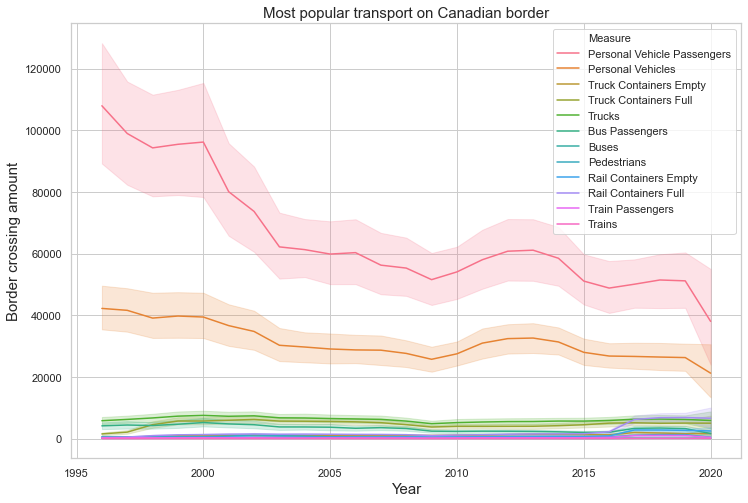

In [20]:
transport_data_Canada = dataset[dataset['Border'] == 'US-Canada Border']

transport_Canada_overview = transport_data_Canada.groupby('Measure')['Value'].sum()
transport_Canada_overview.sort_values(ascending=False, inplace=True)                                                  
                              
print('Most popular transport on Canadian border')
for i, (transport, value) in enumerate(zip(transport_Canada_overview.index, transport_Canada_overview)):
    print(f"{i+1}. {transport}: {value}")                    
                                             
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Value', hue='Measure', data=transport_data_Canada)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Border crossing amount', fontsize=15)
plt.title('Most popular transport on Canadian border', fontsize=15)
plt.show()

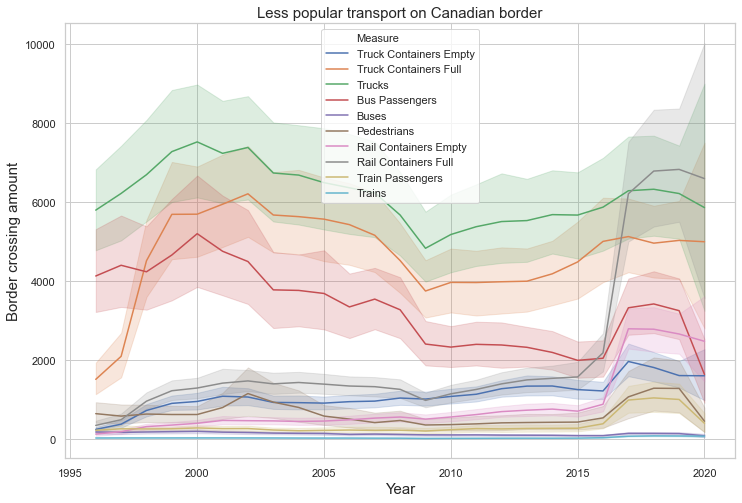

In [21]:
transport_data_Canada_low = transport_data_Canada[(transport_data_Canada['Measure'] != 'Personal Vehicle Passengers') &
                                                  (transport_data_Canada['Measure'] != 'Personal Vehicles')]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Value', hue='Measure', data=transport_data_Canada_low)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Border crossing amount', fontsize=15)
plt.title('Less popular transport on Canadian border', fontsize=15)
plt.show()                                                

From both plots we notice how travelling as a passenger in a car has been steadily decreasing and how crossing the border individually in the personal vehicle remained as popular as it was. On the Canadian border, people seem to be more comfortable with crossing to US, due to the way of how they travelling - in trucks (as regular passengers), buses and in recent years as just pedestrians. That could mean, that restrictions from US has become/are less strict for Candian citizens.

##### Most popular states

State
TX    3747879529
CA    2602572970
AZ     918287879
NY     854042599
MI     775410321
WA     521397911
ME     236781464
VT     118116868
MN      99126985
ND      78600964
NM      68560332
MT      56139436
ID      21833390
AK      14676856
OH           607
Name: Value, dtype: int64


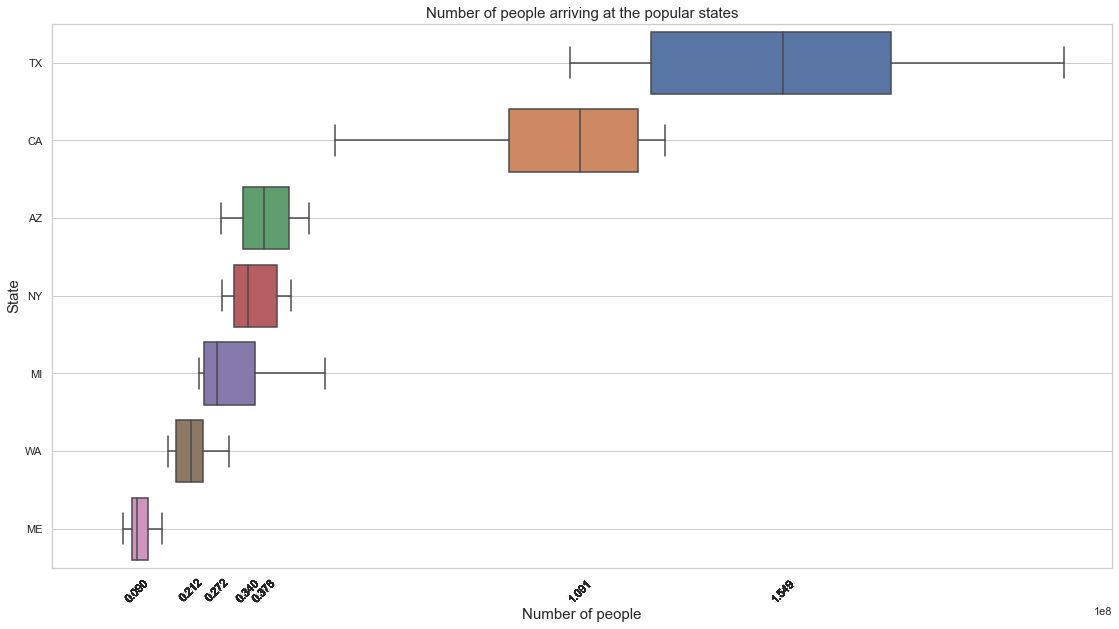

In [22]:
print(dataset.groupby('State')['Value'].sum().sort_values(ascending=False))

# popular states
popular_state_data = pd.DataFrame()
popular_states = ['TX', 'CA', 'AZ', 'NY', 'MI', 'WA', 'ME']
for state in popular_states:
    current_state = pd.DataFrame(dataset[dataset['State'] == state].groupby('Year')['Value'].sum())
    current_state['State'] = state
    current_state['Median'] = current_state['Value'].median()
    popular_state_data = pd.concat([popular_state_data, current_state], ignore_index=True)

plt.figure(figsize = (19, 10))
sns.boxplot(x = 'Value', y = 'State', data=popular_state_data, fliersize = 0)
plt.title('Number of people arriving at the popular states', fontsize = 15)
plt.xlabel('Number of people', fontsize = 15)
plt.ylabel('State', fontsize = 15)
plt.xticks(popular_state_data['Median'], rotation=45)
plt.grid()
plt.show()

The states abuting Mexico are: Texas (TX), New Mexico (N.Mex), Arizona (AZ) and California (CA). For Canada these are: Washington (WA), Idaho (ID), Montana (MT), North Dakota (ND), Minnesota (MN), Vermont (VT), New Hampshire (NH), New York (NY), Maine (ME) and Michigan (MI). Therefore, we can assume that people just tend to travel to states that are the closest.

##### Unpopular states

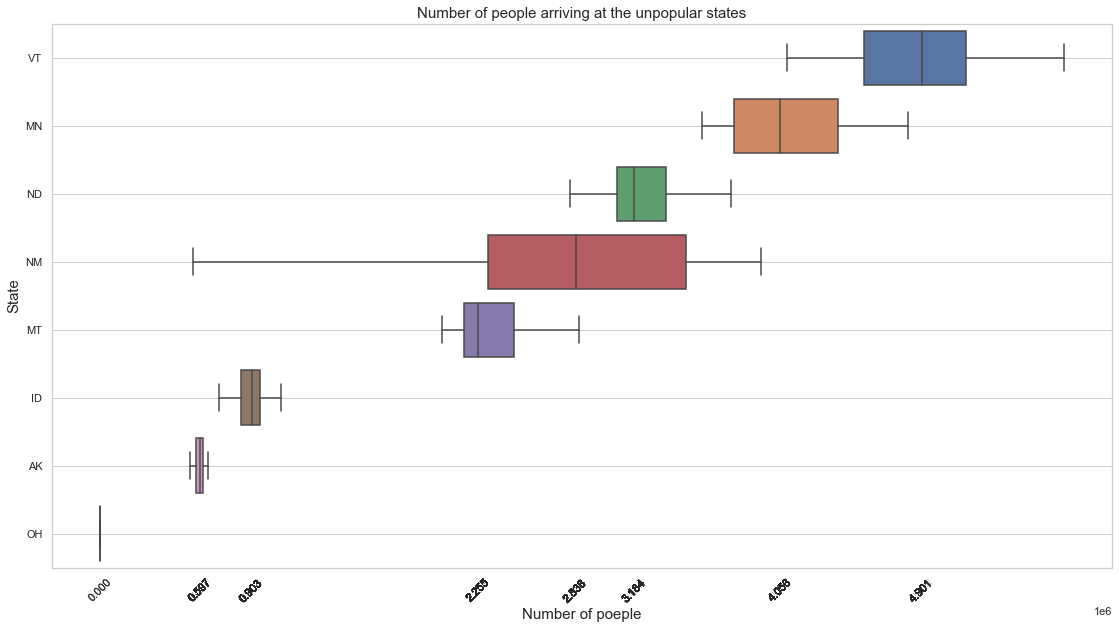

In [26]:
less_popular_state_data = pd.DataFrame()
less_popular_states = ['VT', 'MN', 'ND', 'NM', 'MT', 'ID', 'AK', 'OH']
for state in less_popular_states:
    current_state = pd.DataFrame(dataset[dataset['State'] == state].groupby('Year')['Value'].sum())
    current_state['State'] = state
    current_state['Median'] = current_state['Value'].median()
    less_popular_state_data = pd.concat([less_popular_state_data, current_state], ignore_index=True)
    
plt.figure(figsize = (19, 10))
sns.boxplot(x = 'Value', y = 'State', data=less_popular_state_data, fliersize = 0)
plt.title('Number of people arriving at the unpopular states', fontsize = 15)
plt.xlabel('Number of poeple', fontsize = 15)
plt.ylabel('State', fontsize = 15)
plt.xticks(less_popular_state_data['Median'], rotation=45)
plt.grid()
plt.show()

### Time series forecasting with LSTM
#### LSTM attempt #1

##### Data preparation

In [12]:
data = dataset[['Value', 'Month', 'Year']]
years = list(dataset['Year'].value_counts().index)
years.sort()
print(years)

[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [14]:
# for each month in each year we calculate the total sum of number of border crossings
feed_data = pd.DataFrame()
for year in years:
    data_each_year = data[data['Year'] == year]
    month_in_year = pd.DataFrame(data_each_year.groupby('Month')['Value'].sum())
    feed_data = pd.concat([feed_data, month_in_year], ignore_index=True)
feed_data.head()

,Value
0,35690321
1,40728924
2,32279315
3,32212625
4,32550342


Now, we have to scale the features in order to fit them to the neural network. It is worth mentioning that values should be in range from (0, 1), for that we will use MinMaxScaler.

In [15]:
feed_data_scaled = np.array(feed_data).reshape(-1, 1)

# Scaling
scaler = MinMaxScaler()
feed_data_scaled = scaler.fit_transform(feed_data_scaled)

feed_data_scaled

array([[0.46083531],
       [0.6481129 ],
       [0.33405314],
       [0.33157437],
       [0.34412682],
       [0.63340296],
       [0.53670789],
       [0.45409858],
       [0.5334688 ],
       [0.3608707 ],
       [0.46913958],
       [0.47962702],
       [0.57017516],
       [0.91755163],
       [0.70973413],
       [0.31493754],
       [0.35035735],
       [0.87000881],
       [0.7481423 ],
       [0.68610251],
       [0.72945971],
       [0.66319732],
       [0.69622894],
       [0.72317729],
       [0.69713332],
       [0.87496888],
       [0.71176071],
       [0.524743  ],
       [0.64155057],
       [0.81250315],
       [0.73514568],
       [0.70598055],
       [0.76070887],
       [0.63686176],
       [0.73127796],
       [0.68219346],
       [0.7341076 ],
       [0.9573696 ],
       [0.80073019],
       [0.60437087],
       [0.67661743],
       [0.94194431],
       [0.85100416],
       [0.80447622],
       [0.90858784],
       [0.71523315],
       [0.81675136],
       [0.813

##### Train test split

In [19]:
train, test = train_test_split(feed_data_scaled, test_size=0.3, shuffle=False)

def array_to_matrix_with_shift(dataset, look_back=1):
    data_X = []
    data_y = []
    for i in range(len(dataset)-look_back):
        element = dataset[i:(i+look_back), 0]
        data_X.append(element)
        data_y.append(dataset[i+look_back, 0])
    return np.array(data_X), np.array(data_y)

look_back = 1
train_X, train_y = array_to_matrix_with_shift(np.array(train).reshape(-1, 1))
test_X, test_y = array_to_matrix_with_shift(np.array(test).reshape(-1, 1))

print(train_X[:10])
print(train_y[:10])

[[0.46083531]
 [0.6481129 ]
 [0.33405314]
 [0.33157437]
 [0.34412682]
 [0.63340296]
 [0.53670789]
 [0.45409858]
 [0.5334688 ]
 [0.3608707 ]]
[0.6481129  0.33405314 0.33157437 0.34412682 0.63340296 0.53670789
 0.45409858 0.5334688  0.3608707  0.46913958]
202


Some clarification - train_y and test_y are the target values and train_X and test_X are the features based on which the forecast is going to be made.
##### LSTM requires a 3-D array of shape N x D x T
- N - number of samples (len(train_X))
- D - time stamps (in our case it's 1)
- T - number of observations (look_back)

In [20]:
print("train_X.shape", train_X.shape)

train_X.shape (202, 1)


Let's fix the dimensions

In [21]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("train_X.shape", train_X.shape)

# train_X - Jan 1996 - Oct 2012
# test_X - Dec 2012 - Feb 2020

train_X.shape (202, 1, 1)


##### Neural network model
- input layer being LSTM with 20 units,
- one Dense layer with one output
- using 'Adam' optimizer and Mean Absolute Error as the loss function

Train on 202 samples, validate on 86 samples
Epoch 1/40
202/202 [==============================] - 5s 27ms/sample - loss: 0.4733 - val_loss: 0.1920
Epoch 2/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.3626 - val_loss: 0.0954
Epoch 3/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.2463 - val_loss: 0.0833
Epoch 4/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1606 - val_loss: 0.1688
Epoch 5/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1402 - val_loss: 0.1663
Epoch 6/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1353 - val_loss: 0.1634
Epoch 7/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1305 - val_loss: 0.1551
Epoch 8/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1261 - val_loss: 0.1482
Epoch 9/40
202/202 [==============================] - 0s 1ms/sample - loss: 0.1218 - val_loss: 0.1336
Epoch 10/40
202/202 [===============

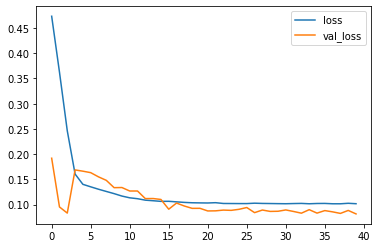

In [22]:
# neural network using LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mae')

r = model.fit(train_X, train_y, epochs=40, batch_size=5, validation_data=(test_X, test_y))

# plot history
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

##### Forecasting 

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 2797696.123


##### Plot data preparation

In [28]:
# months corresponding to predicted values
month_idx_start = np.array([[12]]) # wraps up 2012
month_idx_mid = np.arange(1, 13) # returns 1-12
# months for 2013, 2014, 2015, 2016, 2017, 2018, 2019
month_idx_mid = np.tile(month_idx_mid, 7).reshape(-1, 1)
month_idx_end = np.array([[1]]) # wraps up 2020 (there's only Jan in 2020)
full_months = np.concatenate((month_idx_start, month_idx_mid, month_idx_end))

# prepare inverted y data
inv_y_df = pd.DataFrame(inv_y, columns=['Value'])
inv_y_df['Month'] = full_months
inv_y_df['Month'] = inv_y_df['Month'].astype(int)
inv_y_df['Month'] = inv_y_df['Month'].apply(lambda x: calendar.month_abbr[x])
inv_y_df['Type'] = 'Actual'

# prepare inverted yhat data
inv_yhat_df = pd.DataFrame(inv_yhat, columns=['Value'])
inv_yhat_df['Month'] = full_months
inv_yhat_df['Month'] = inv_yhat_df['Month'].astype(int)
inv_yhat_df['Month'] = inv_yhat_df['Month'].apply(lambda x: calendar.month_abbr[x])
inv_yhat_df['Type'] = 'Predicted'

full_results_df = pd.concat([inv_y_df, inv_yhat_df])
full_results_df.head()

,Value,Month,Type
0,27875179.0,Dec,Actual
1,34512545.0,Jan,Actual
2,31203635.0,Feb,Actual
3,25226815.0,Mar,Actual
4,27067906.0,Apr,Actual


In [29]:
start_years = np.array([2012])
# append years, that is 2013 - 2019 (12 times each) + 2 times 2020
mid_years = np.array([2013, 2014, 2015, 2016, 2017, 2018, 2019])
mid_years = np.repeat(mid_years, 12)
last_years = np.array([2020])
years = []
years = np.append(start_years, mid_years)
years = np.append(years, last_years)
years = np.tile(years, 2)

full_results_df['Year'] = years

full_results_df['Date'] = full_results_df['Month'] + full_results_df['Year'].astype(str)
ordered_dates = full_results_df['Date'].unique()
full_results_df['Date'] = pd.Categorical(full_results_df['Date'], categories=ordered_dates,
               ordered=True)

full_results_df.head()

,Value,Month,Type,Year,Date
0,27875179.0,Dec,Actual,2012,Dec2012
1,34512545.0,Jan,Actual,2013,Jan2013
2,31203635.0,Feb,Actual,2013,Feb2013
3,25226815.0,Mar,Actual,2013,Mar2013
4,27067906.0,Apr,Actual,2013,Apr2013


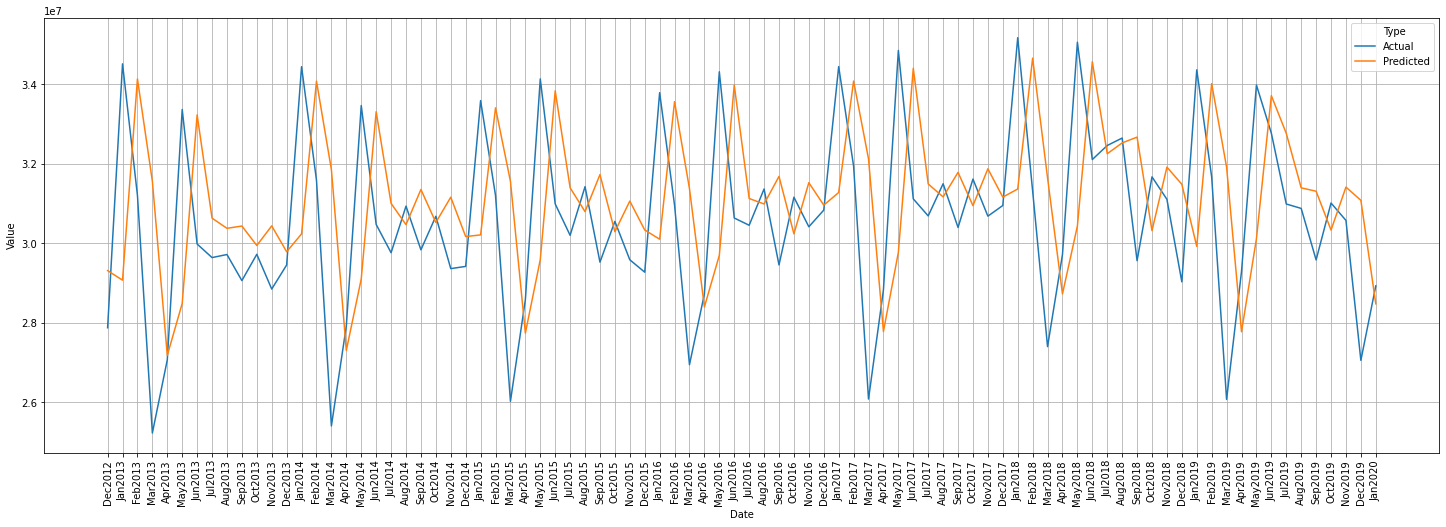

In [26]:
plt.figure(figsize=(25, 8))
sns.lineplot(x='Date', y='Value', hue='Type', data=full_results_df)
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Now, this looks amazing however, I am a bit sceptical due to how perfect it looks like. The problem with it may be the fact that forecasting has been based on true values. What I mean by that - a t+1 value is being predicted by the t value (being a true value) and t+2 value is being predicted using t+1 true value instead of the forecasted one.

#### LSTM attempt #2

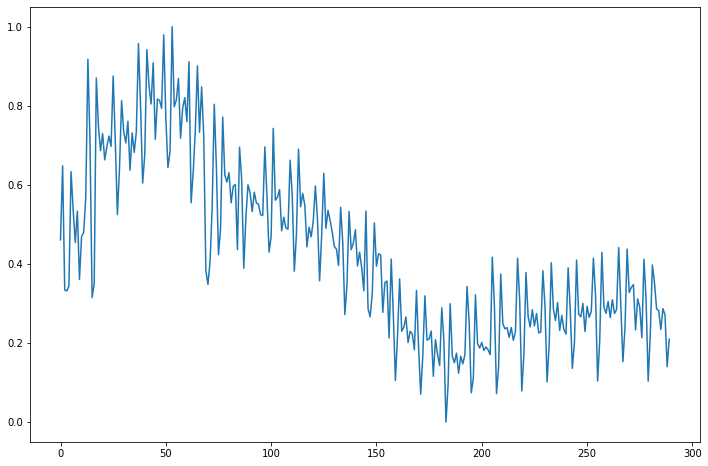

In [44]:
sequence = np.array(feed_data_scaled)

plt.figure(figsize=(12, 8))
plt.plot(sequence)
plt.show()

##### Data preparation

In [176]:
T = 10
D = 1
X = []
Y = []

for t in range(len(sequence)-T):
    x = sequence[t:t+T] # (0:9), (1:10), (2:11)... returns values for these indices
    X.append(x)
    y = sequence[t+T] # 10, 11, 12... these are the target indices for each x
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X) # number of samples
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (280, 10) Y.shape (280, 1)


##### Building the neural network model

In [177]:
X = X.reshape(-1, T, D) # make it N x T x D

i = Input(shape=(T, D))
x = LSTM(80)(i)
x = Dense(1)(x)

model = Model(i, x)

model.compile(
    loss='mae',
    optimizer=Adam(lr=0.005)        
)

r = model.fit(
    X[:N//2], Y[:N//2],
    epochs=100,
    validation_data=(X[N//2:], Y[N//2:])
)

Train on 140 samples, validate on 140 samples
Epoch 1/100
140/140 [==============================] - 3s 21ms/sample - loss: 0.2928 - val_loss: 0.0972
Epoch 2/100
140/140 [==============================] - 0s 343us/sample - loss: 0.1509 - val_loss: 0.0685
Epoch 3/100
140/140 [==============================] - 0s 336us/sample - loss: 0.1100 - val_loss: 0.1252
Epoch 4/100
140/140 [==============================] - 0s 357us/sample - loss: 0.1051 - val_loss: 0.0881
Epoch 5/100
140/140 [==============================] - 0s 415us/sample - loss: 0.0912 - val_loss: 0.1277
Epoch 6/100
140/140 [==============================] - 0s 386us/sample - loss: 0.0983 - val_loss: 0.0947
Epoch 7/100
140/140 [==============================] - 0s 400us/sample - loss: 0.0948 - val_loss: 0.0977
Epoch 8/100
140/140 [==============================] - 0s 379us/sample - loss: 0.0934 - val_loss: 0.0835
Epoch 9/100
140/140 [==============================] - 0s 365us/sample - loss: 0.0931 - val_loss: 0.0818
Epoch 10/1

Epoch 78/100
140/140 [==============================] - 0s 350us/sample - loss: 0.0885 - val_loss: 0.0920
Epoch 79/100
140/140 [==============================] - 0s 343us/sample - loss: 0.0945 - val_loss: 0.0615
Epoch 80/100
140/140 [==============================] - 0s 357us/sample - loss: 0.0831 - val_loss: 0.0708
Epoch 81/100
140/140 [==============================] - 0s 364us/sample - loss: 0.0798 - val_loss: 0.0598
Epoch 82/100
140/140 [==============================] - 0s 357us/sample - loss: 0.0809 - val_loss: 0.0690
Epoch 83/100
140/140 [==============================] - 0s 365us/sample - loss: 0.0838 - val_loss: 0.0618
Epoch 84/100
140/140 [==============================] - 0s 350us/sample - loss: 0.0800 - val_loss: 0.0555
Epoch 85/100
140/140 [==============================] - 0s 365us/sample - loss: 0.0805 - val_loss: 0.0556
Epoch 86/100
140/140 [==============================] - 0s 365us/sample - loss: 0.0784 - val_loss: 0.0542
Epoch 87/100
140/140 [========================

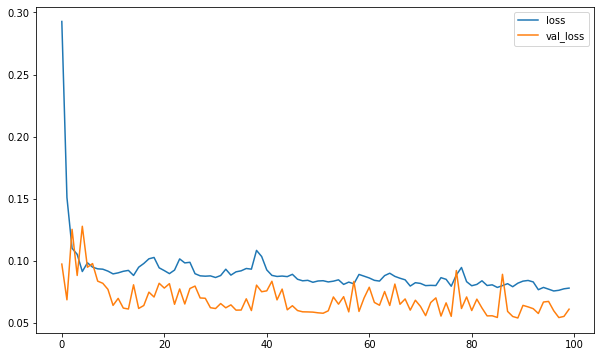

In [178]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(280, 1)


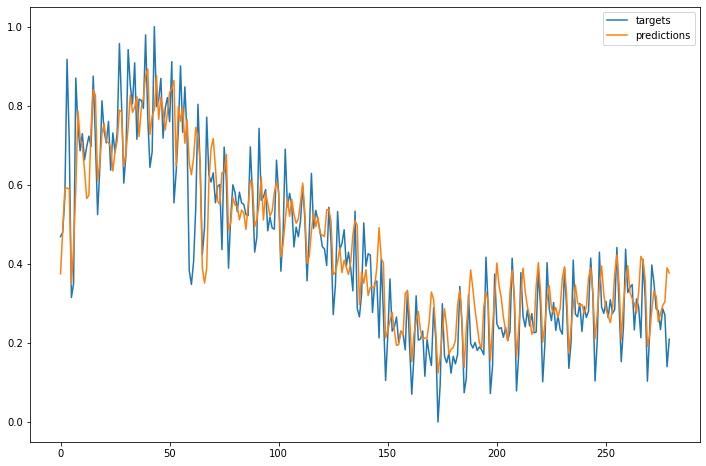

In [179]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.figure(figsize=(12, 8))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

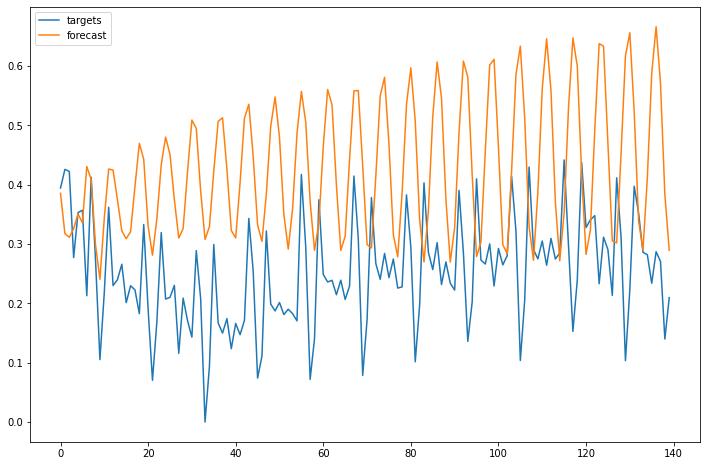

In [180]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
    # reshape the input_ to N x T x D
    f = model.predict(input_.reshape(1, T, D))[0, 0]
    forecast.append(f)
    
    # make a new input with the latest forecast
    input_ = np.roll(input_, -1)
    input_[-1] = f

plt.figure(figsize=(12, 8))
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()